In [1]:
%pip install qiskit qiskit-ibm-runtime

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time, copy

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons, make_circles, make_classification, make_blobs
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve


from matplotlib.colors import ListedColormap
cm = plt.cm.RdBu
cm_bright = ListedColormap(["#FF0000", "#0000FF"])

import pandas as pd
import scipy.io
import numpy as np
from scipy.spatial.distance import pdist, squareform
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
#%matplotlib inline
import tensorflow as tf
import time

rand_state = 42

# Set random seeds
tf.random.set_seed(rand_state)
np.random.seed(rand_state)

import warnings
warnings.simplefilter('ignore')


qm7 = scipy.io.loadmat('qm7.mat')

R = qm7['R']

y = np.transpose(qm7['T']).reshape((7165,))
y_scaling_factor = 2000.
y_scaled = y / y_scaling_factor

# k=0 # 0 = include diagnol, 1 = do not include diagnol

num_atoms = 23
iu = np.triu_indices(num_atoms,k=0)
iu_dist = np.triu_indices(num_atoms,k=1) # for the pairwise distance matrix, all diagonol entries will be 0


CM = np.zeros((qm7['X'].shape[0], num_atoms*(num_atoms+1)//2), dtype=float)
eigs = np.zeros((qm7['X'].shape[0], num_atoms), dtype=float)
centralities = np.zeros((qm7['X'].shape[0], num_atoms), dtype=float)
interatomic_dist = np.zeros((qm7['X'].shape[0], ((num_atoms*num_atoms)-num_atoms)//2), dtype=float)

verbose=True

for i, cm in enumerate(qm7['X']):
    coulomb_vector = cm[iu]
    # Sort elements by decreasing order
    shuffle = np.argsort(-coulomb_vector)
    CM[i] = coulomb_vector[shuffle]
    dist = squareform(pdist(R[i]))
    # we can extract the upper triangle of the distance matri: return vector of dimension (1,num_atoms)
    dist_vector = dist[iu_dist]
    shuffle = np.argsort(-dist_vector)
    interatomic_dist[i] = dist_vector[shuffle]

    w,v = np.linalg.eig((dist))
    eigs[i] = w[np.argsort(-w)]
    centralities[i] = np.array(list(nx.eigenvector_centrality(nx.Graph(dist)).values()))

    if verbose and i % 500 == 0:
        print("Processed {} molecules".format(i))

X = np.concatenate((CM, eigs, centralities, interatomic_dist), axis=1)
from sklearn.decomposition import KernelPCA
from matplotlib import cm

# scale Coulomb Matrices, divide by 370
CM = qm7['X'].reshape((7165, 529))


start_time = time.time()
kpca = KernelPCA(n_components=2, kernel="rbf")
CM_reduced = kpca.fit_transform(CM)
print("--- %s seconds ---" % (time.time() - start_time))
explained_variance = np.var(CM_reduced, axis=0)
explained_variance_ratio = explained_variance / np.sum(explained_variance)
print("Variance Explained: ", np.sum(explained_variance_ratio))
print(y)


def get_category(x, total_range, num_bins):
    bin_size = total_range/num_bins
    total_range = 1787.119995
    bin_size = total_range/num_bins

    return int(np.floor(np.abs(x/bin_size)))

total_range = 1787.119995
num_bins = 10
X = X.astype(float)


y_class = pd.Series(y).apply(lambda x: get_category(x, total_range, num_bins))

df = pd.DataFrame(X)
df['label'] = y_class
df
zero_counts = (df == 0).sum().sort_values(ascending=True)

# Display the counts of zeroes in ascending order
print(zero_counts)
X = df.drop('label', axis=1)  # Assuming 'target' is the name of the target variable column
y = df['label']


Processed 0 molecules
Processed 500 molecules
Processed 1000 molecules
Processed 1500 molecules
Processed 2000 molecules
Processed 2500 molecules
Processed 3000 molecules
Processed 3500 molecules
Processed 4000 molecules
Processed 4500 molecules
Processed 5000 molecules
Processed 5500 molecules
Processed 6000 molecules
Processed 6500 molecules
Processed 7000 molecules
--- 1.5403118133544922 seconds ---
Variance Explained:  1.0
[ -417.96  -712.42  -564.21 ... -1662.1  -1782.01 -1919.  ]
0         0
323       0
324       0
325       0
326       0
       ... 
270    7156
271    7156
272    7156
275    7156
273    7156
Length: 576, dtype: int64


In [5]:
y

0        2
1        3
2        3
3        2
4        4
        ..
7160    10
7161     9
7162     9
7163     9
7164    10
Name: label, Length: 7165, dtype: int64

In [6]:
pip install qiskit.algorithms

Note: you may need to restart the kernel to use updated packages.


In [7]:
from qiskit_algorithms.state_fidelities import ComputeUncompute
from qiskit.primitives import Sampler

fidelity = ComputeUncompute(sampler=Sampler())

In [8]:
pip install qiskit_machine_learning

Note: you may need to restart the kernel to use updated packages.


In [9]:
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit.circuit.library import ZZFeatureMap
from qiskit.primitives import Sampler
from qiskit_machine_learning.kernels import FidelityQuantumKernel
feature_map = ZZFeatureMap(2)
new_kernel = FidelityQuantumKernel(feature_map=feature_map, fidelity=fidelity)


In [24]:
import pandas as pd
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Assuming df and y_class are defined elsewhere
col = [320, 321, 319, 301, 302, 299, 303, 304, 84, 319,50,55]
x_new = df[col]
df2 = pd.DataFrame(x_new)
df2['label'] = y_class

# Set features and target variable
features = df2.drop('label', axis=1)
y = df2['label']

# Train-Test Split
train_features, test_features, train_labels, test_labels = train_test_split(
    features, y, train_size=0.8
)

# Define and fit the SVR model
svr = SVR()
svr.fit(train_features, train_labels)

# Calculate the training and test scores
train_score_svr = svr.score(train_features, train_labels)
test_score_svr = svr.score(test_features, test_labels)

# Calculate the Mean Squared Error (MSE) for both training and test sets
train_mse = mean_squared_error(train_labels, svr.predict(train_features))
test_mse = mean_squared_error(test_labels, svr.predict(test_features))

# Print the results
print(f"SVR on the training dataset (R^2 score): {train_score_svr:.2f}")
print(f"SVR on the test dataset (R^2 score):     {test_score_svr:.2f}")
print(f"Mean Squared Error on training set:      {train_mse:.2f}")
print(f"Mean Squared Error on test set:          {test_mse:.2f}")


SVR on the training dataset (R^2 score): 0.88
SVR on the test dataset (R^2 score):     0.88
Mean Squared Error on training set:      0.20
Mean Squared Error on test set:          0.18


In [10]:
pip install qiskit_machine_learning

Note: you may need to restart the kernel to use updated packages.


In [15]:
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_algorithms.optimizers import COBYLA, L_BFGS_B
from IPython.display import clear_output

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC

feature_map = ZZFeatureMap(4)
ansatz = RealAmplitudes(4, reps=3)

def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()
# construct variational quantum classifier
vqc = VQC(
    num_qubits=4,
    optimizer=COBYLA(maxiter=30),
    callback=callback_graph,
)
from sklearn.decomposition import PCA

In [12]:
import pandas as pd

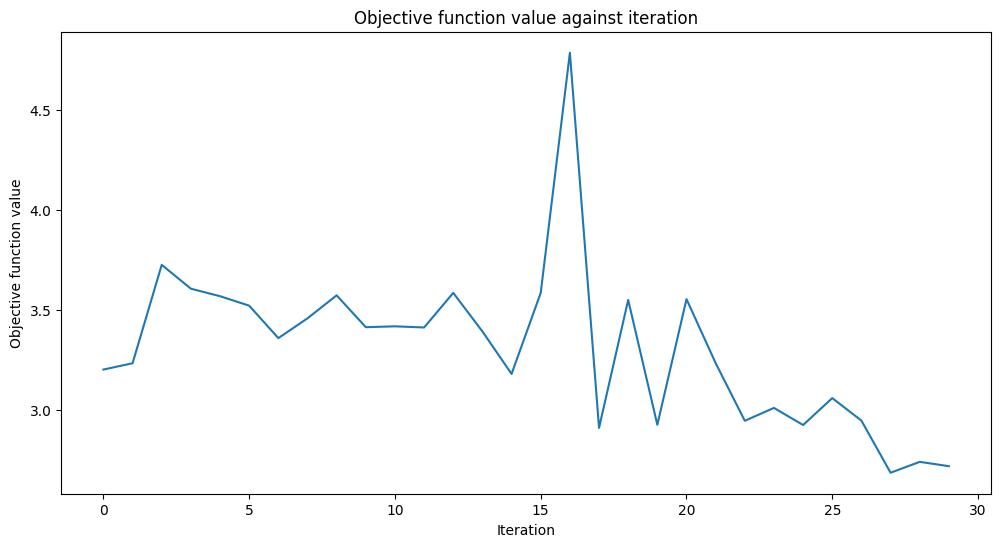

Test Score: 0.22417643774427695


In [16]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and 'y_class' is your target variable
col = [320, 321, 319, 301, 302, 299, 303, 304, 84, 319]
x_new = df[col]
df2 = pd.DataFrame(x_new)
df2['label'] = y_class

# Prepare X and y
X = df2.drop('label', axis=1)
y = df2['label'].values

# Convert column types if needed
x_new.columns = x_new.columns.astype(str)

# Perform PCA
features = PCA(n_components=4).fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.5, random_state=42)

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# Fit the classifier to the training data
vqc.fit(X_train, y_train)

# Return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# Score the classifier on the test data
score = vqc.score(X_train, y_train)
print("Test Score:", score)


In [14]:
#pennylane=98 , vqc=0.9166

In [15]:
from sklearn.metrics import precision_recall_fscore_support


In [18]:
qsvc_predictions = vqc.predict(test_features[:120])
precision, recall, f1_score, _ = precision_recall_fscore_support(test_labels[:120:], qsvc_predictions, average='weighted')

# Print the results
print(f"VQC Classification Test Metrics:")
print(f"Weighted Precision: {precision:.4f}")
print(f"Weighted Recall: {recall:.4f}")
print(f"Weighted F1 Score: {f1_score:.4f}")

NameError: name 'test_features' is not defined